## Abstract draft

Phenomenological observation of reward processing suggests that humans value rewards in a relative manner: rewards are often not only valued according to their magnitude but also relative to other rewards. Previous work has demonstrated the importance of the orbitofrontal cortex (OFC) in “relative reward processing”, but macro-level analysis of the most active cortical regions in this process is still lacking. . Here, we use fMRI data from a gambling task to test whether certain regions of the reward processing circuit respond preferentially to a reward stimulus after a streak of bad luck (representing low-value rewards in the temporal vicinity) compared to the same stimulus after a streak of good luck (high-value rewards in the temporal vicinity). The data was collected during a gambling task, in which subjects were asked to guess whether the value of a hidden card was larger or smaller than 5. Correct and incorrect guesses would respectively lead to the gain and loss of a set amount of money. We use a generalized linear model (GLM) to compare how low-value (a win after a streak of good luck) and high-value (a win after a streak of bad luck) relative rewards predict activity for each separate cortical region. We expect to find increased activity in the cortical elements of the reward processing network upon receiving a high-value relative reward compared to a low-value relative reward. These regions potentially include the medial prefrontal, orbitofrontal, and anterior cingulate cortex. From these expected findings, we might conclude that the brain processes reward in at least a partially relative manner. Future research should utilize data from a hypothesis-specific task to explore the contributions of subcortical components to relative reward processing and disentangle relative reward from confounding factors such as prediction error processing activity.


# Load HCP parcellated task data 
## (version with Behavioural Data)

The HCP dataset comprises task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In order to use this dataset, please electronically sign the HCP data use terms at [ConnectomeDB](https://db.humanconnectome.org). Instructions for this are on pp. 24-25 of the [HCP Reference Manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

In this notebook, NMA provides code for downloading the data and doing some basic visualisation and processing.

In [1]:
# @title Install dependencies
!pip install nilearn --quiet

     |████████████████████████████████| 9.6 MB 23.7 MB/s 


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from scipy import stats

In [3]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [4]:
# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win', 'loss_event', 'win_event']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}

> For a detailed description of the tasks have a look pages 45-54 of the [HCP reference manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

# Downloading data

The task data are shared in different files, but they will unpack into the same directory structure.


In [5]:
# @title Download data file
import os, requests

fname = "hcp_task.tgz"
url = "https://osf.io/2y3fw/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [6]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp_task"

# importing the "tarfile" module
import tarfile

# open file
with tarfile.open(fname) as tfile:
  # extracting file
  tfile.extractall('.')

subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')

## Understanding the folder organisation

The data folder has the following organisation:

- hcp
  - regions.npy (information on the brain parcellation)
  - subjects_list.txt (list of subject IDs)
  - subjects (main data folder)
    - [subjectID] (subject-specific subfolder)
      - EXPERIMENT (one folder per experiment)
        - RUN (one folder per run)
          - data.npy (the parcellated time series data)
          - EVs (EVs folder)
            - [ev1.txt] (one file per condition)
            - [ev2.txt]
            - Stats.txt (behavioural data [where available] - averaged per run)
            - Sync.txt (ignore this file)



## Loading region information

Downloading this dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).



In [7]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

In [127]:
regions

array([['R_V1', 'R_MST', 'R_V6', ..., 'L_PI', 'L_a32pr', 'L_p24'],
       ['Visual1', 'Visual2', 'Visual2', ..., 'Cingulo-Oper',
        'Cingulo-Oper', 'Cingulo-Oper'],
       ['2.209', '2.05561', '2.1498', ..., '1.74335', '1.73082',
        '1.65968']], dtype='<U12')

In [8]:
print(region_info['network'])

['Visual1' 'Visual2' 'Visual2' 'Visual2' 'Visual2' 'Visual2' 'Visual2'
 'Somatomotor' 'Somatomotor' 'Cingulo-Oper' 'Language' 'Default' 'Visual2'
 'Frontopariet' 'Frontopariet' 'Visual2' 'Visual2' 'Visual2' 'Visual2'
 'Visual2' 'Visual2' 'Visual2' 'Visual2' 'Auditory' 'Default' 'Default'
 'Dorsal-atten' 'Default' 'Frontopariet' 'Posterior-Mu' 'Posterior-Mu'
 'Posterior-Mu' 'Posterior-Mu' 'Posterior-Mu' 'Posterior-Mu' 'Somatomotor'
 'Cingulo-Oper' 'Cingulo-Oper' 'Somatomotor' 'Somatomotor' 'Somatomotor'
 'Somatomotor' 'Cingulo-Oper' 'Cingulo-Oper' 'Cingulo-Oper' 'Language'
 'Somatomotor' 'Visual2' 'Visual2' 'Language' 'Somatomotor' 'Somatomotor'
 'Somatomotor' 'Somatomotor' 'Somatomotor' 'Somatomotor' 'Cingulo-Oper'
 'Cingulo-Oper' 'Cingulo-Oper' 'Cingulo-Oper' 'Posterior-Mu'
 'Posterior-Mu' 'Frontopariet' 'Posterior-Mu' 'Posterior-Mu'
 'Posterior-Mu' 'Posterior-Mu' 'Posterior-Mu' 'Posterior-Mu'
 'Posterior-Mu' 'Posterior-Mu' 'Posterior-Mu' 'Frontopariet' 'Default'
 'Default' 'Posterior

# Help functions

We provide two helper functions: one for loading the time series from a single subject and a single run, and one for loading an EV file for each task. 

An EV file (EV:Explanatory Variable) describes the task experiment in terms of stimulus onset, duration, and amplitude. These can be used to model the task time series data.

In [9]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment
    run (int):          (0 or 1)
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  for cond in EXPERIMENTS[experiment]['cond']:
    ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list

In [10]:
def sortThird(val):
    return val[2]

# Example run

Let's load the timeseries data for the GAMBLING experiment from a single subject and a single run

In [11]:
my_exp = 'GAMBLING'
my_subj = subjects[0]
my_run = 0

data = load_single_timeseries(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=False)
print(data.shape)

(360, 253)


As you can see the time series data contains 253 time points in 360 regions of interest (ROIs).



Now in order to understand how to model these data, we need to relate the time series to the experimental manipulation. This is described by the EV files. Let us load the EVs for this experiment.

In [142]:
evs = load_evs(subject=my_subj, experiment=my_exp, run=my_run)


In [87]:
evs_delayed = [list(np.array(ev) + int(5/TR)) for ev in evs]


In [92]:
np.array(evs[3]).max()

233

In [96]:
np.array(evs_delayed[3])[:-1,:-1].max()
np.array(evs_delayed[0])[:,:-6].max()

233

In [95]:
evs_delayed[3]

[array([27, 28, 29, 30, 31]),
 array([37, 38, 39, 40, 41]),
 array([78, 79, 80, 81, 82]),
 array([88, 89, 90, 91, 92]),
 array([93, 94, 95, 96, 97]),
 array([ 98,  99, 100, 101, 102]),
 array([103, 104, 105, 106, 107]),
 array([113, 114, 115, 116, 117]),
 array([149, 150, 151, 152, 153]),
 array([159, 160, 161, 162, 163]),
 array([200, 201, 202, 203, 204]),
 array([205, 206, 207, 208, 209]),
 array([215, 216, 217, 218, 219]),
 array([225, 226, 227, 228, 229]),
 array([230, 231, 232, 233, 234]),
 array([235, 236, 237, 238, 239])]

In [102]:
max(evs[1][1])

232

# Organize data

In [81]:
# win/loss, Block, order
def wBo(evs):

  Condition = []
  Win_Status = np.hstack((np.zeros(len(evs[2])), np.ones(len(evs[3])))) #win

  Block_data = np.array(evs[:2])
  Block_min = np.reshape(Block_data, (Block_data.shape[0] * Block_data.shape[1], Block_data.shape[2])).min(axis = 1)
  Block_max = np.reshape(Block_data, (Block_data.shape[0] * Block_data.shape[1], Block_data.shape[2])).max(axis = 1)
  Trials_evs = evs[2].copy()
  Trials_evs.extend(evs[3])
  Trials_evs = [trial_evs[:-1] for trial_evs in Trials_evs]
  Block_num = []
  for trial_evs in Trials_evs:
      min_index = np.where(min(trial_evs) >= Block_min)[0]
      max_index = np.where(max(trial_evs) <= Block_max)[0]
      Block_num.append(np.intersect1d(min_index, max_index)[0] + 1)
  Block_num = np.array(Block_num)

  orders = [int((Trials_evs[i][0] - Block_min[Block_num[i]-1]) / 5) + 1 for i in range(len(Trials_evs))]

  input_matrix = np.vstack((Win_Status, Block_num, orders)).T
  return input_matrix


In [14]:
Block_data = np.array(evs[:2])
Block_min = np.reshape(Block_data, (Block_data.shape[0] * Block_data.shape[1], Block_data.shape[2])).min(axis = 1)
Block_max = np.reshape(Block_data, (Block_data.shape[0] * Block_data.shape[1], Block_data.shape[2])).max(axis = 1)
Trials_evs = evs[2].copy()
Trials_evs.extend(evs[3])
Trials_evs = [trial_evs[:-1] for trial_evs in Trials_evs]
Block_num = []
min_index = np.where(min(Trials_evs[0]) >= Block_min)[0]
max_index = np.where(max(Trials_evs[0]) <= Block_max)[0]
Block_num.append(np.intersect1d(min_index, max_index)[0] + 1)

In [15]:
np.intersect1d(min_index, max_index)[0]

0

## Calculate Gain vector (Y)

In [16]:
# calculate gain vector

def getdcginput(input_matrx, index):
  '''
    input = index of trial whose gain we want to calculate
    output = list of trials whose values are requred to calculate gain
  '''
  dcginput = []
  for i in range(len(input_matrx)):
    if (input_matrx[i][1] == input_matrx[index][1]) & (input_matrx[i][2] <= input_matrx[index][2]):
      dcginput.append(input_matrx[i][:])

  dcginput.sort(key = sortThird)
  return dcginput

def status2gain(status):
  '''
    input = loss (0) or win (1)
    output = gain for loss (-0.5) or win (+1)
  '''
  gain = []
  for i in range(len(status)):
    if status[i][0] == 0:
      gain.append(-0.5)
    else:
      gain.append(1)
  return gain

def dcg(gain):
  '''
    input = list of trials whose values are requred to calculate gain
    output = gain
    gain = $\sum_{i=1}^{t}\frac{\text{Reward_i}{\log_2{t-i+2}}}$
  '''
  dcg = 0
  t = len(gain)
  for i in range(len(gain)):
    dcg += gain[i] / np.log2(t - i + 1)

  return dcg

def dcgvector(input_matrx):
  '''
    uses individual gains provided by dcg() to calculate whole vector of gains
  '''
  dcgv = []
  for i in range(len(input_matrx)):
    dcgv.append(dcg(status2gain(getdcginput(input_matrx, i))))
  return dcgv

gainvector = dcgvector(wBo(evs_delayed))

In [103]:
gainvector = dcgvector(wBo(evs_delayed))

In [179]:
len(gainvector)

30

Text(0.5, 1.0, 'Gains Histogram')

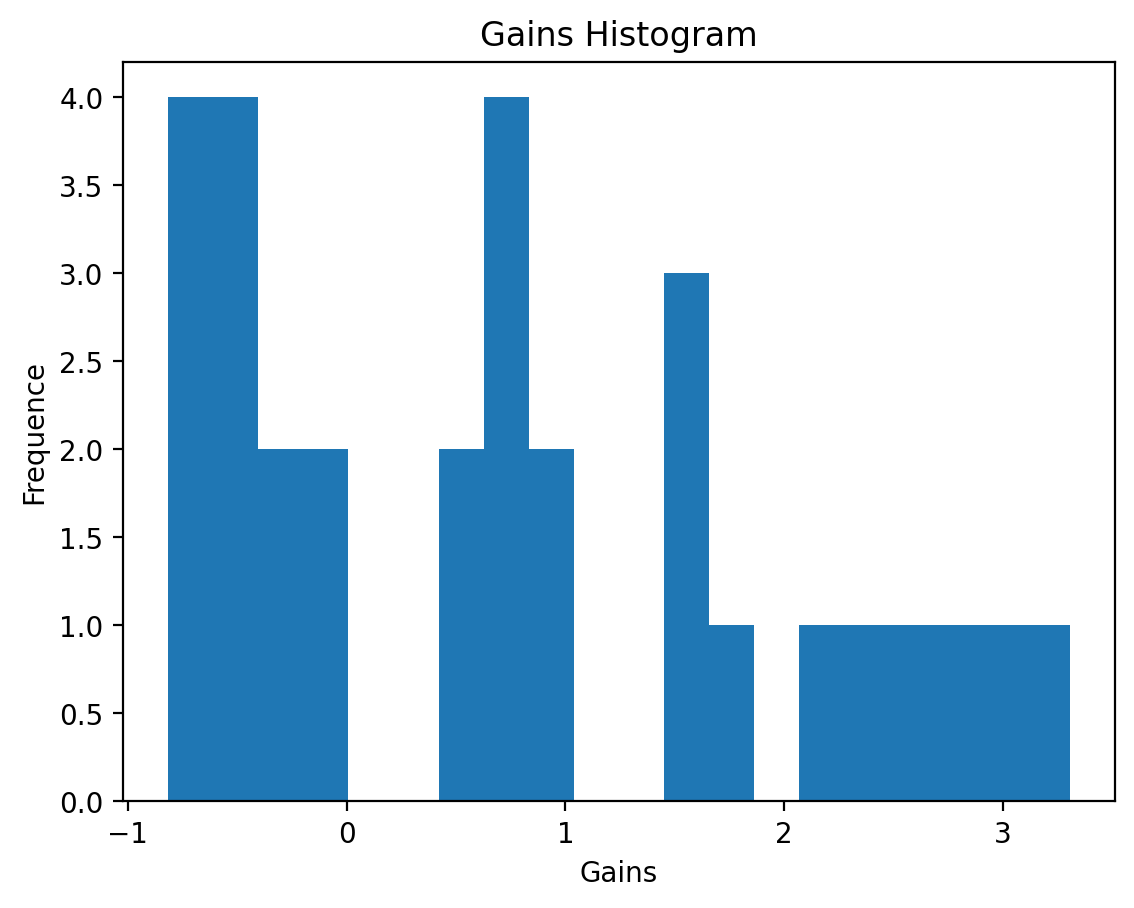

In [183]:
plt.hist(gainvector, bins=20)
plt.xlabel("Gains")
plt.ylabel("Frequence")
plt.title("Gains Histogram")

In [104]:
len(gainvector)

30

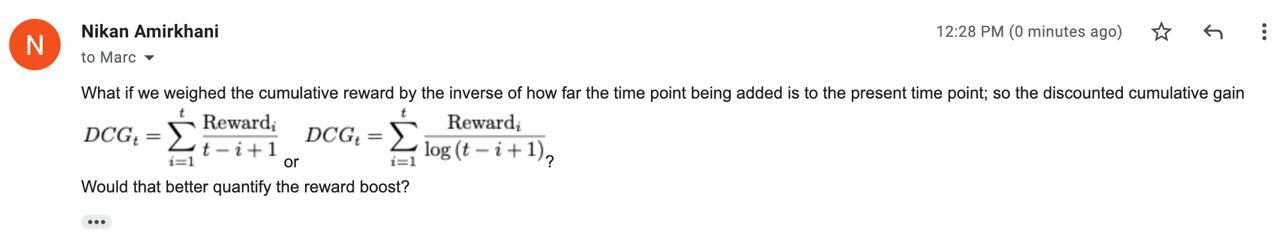

In [105]:
all_loss = np.mean(data[:,evs_delayed[2][:]], axis=2)
all_win = np.mean(data[:,evs_delayed[3][:]], axis=2)
all_data = np.concatenate((all_loss, all_win), axis=1)

In [106]:
all_data_z = stats.zscore(all_data, axis=None)

In [20]:
all_data.shape

(360, 30)

In [21]:
all_data.shape

(360, 30)

In [22]:
all_data_z.shape

(360, 30)

For the gambling task, this evs variable contains a list of 2 arrays corresponding to the 2 conditions. 

Now let's use these evs to compare the average activity during the win ('win') and loss ('loss') conditions:

# Analysis

In [25]:
area_info = pd.read_excel('/content/drive/MyDrive/macro_2hem.xlsx')['area_name'].to_numpy()
area_names = np.unique(area_info)

In [125]:
parcel2area = pd.read_excel('/content/drive/MyDrive/macro_2hem.xlsx').to_numpy()

In [126]:
parcel2area

array([[1, 'R_V1', 'vis_early', 'Early Visual'],
       [2, 'R_MST', 'vis_tpo', 'Visual (TPO)'],
       [3, 'R_V6', 'vis_dors', 'Dorsal Visual'],
       ...,
       [358, 'L_PI', 'insular', 'Insular'],
       [359, 'L_a32pr', 'mpfc_acc', 'ACC & mPFC'],
       [360, 'L_p24', 'mpfc_acc', 'ACC & mPFC']], dtype=object)

In [26]:
np.where(area_info == 'Early Visual')[0]

array([  0,   3,   4,   5, 180, 183, 184, 185])

In [27]:
all_data[np.where(area_info == 'Early Visual')[0]].shape

(8, 30)

In [107]:
def my_linreg(all_data):

  pca = PCA()
  reduced_data = pca.fit_transform(all_data.T)

  # Train/test

  X_train, X_test, y_train, y_test = train_test_split(reduced_data[:,0].reshape(-1,1), gainvector, shuffle=True, test_size=0.20, random_state=42)

  # Regression
  reg = LinearRegression().fit(X_train, y_train)

  y_pred_train = reg.predict(X_train)

  y_pred_test = reg.predict(X_test.reshape(-1,1))

  return np.corrcoef(y_pred_train, y_train)[0,1], np.corrcoef(y_pred_test, y_test)[0,1]

In [29]:
def getscores(data):

  train_score = np.zeros(len(area_names))
  test_score = np.zeros(len(area_names))
  for i, areas in enumerate(area_names):
    idx = np.where(area_info == areas)[0]
    area_data = data[idx, :]
    train_score[i], test_score[i] = my_linreg(area_data)
  return test_score

In [108]:
getscores(all_data_z)

array([ 0.40571868,  0.01854758, -0.37404981, -0.29163088, -0.1175415 ,
        0.12611692,  0.024035  ,  0.17205006,  0.40964515,  0.43332913,
        0.63037106,  0.20141717, -0.20447784, -0.0952398 , -0.04728143,
       -0.25175858,  0.08351716, -0.03121491, -0.23209329, -0.21008957,
       -0.15107793])

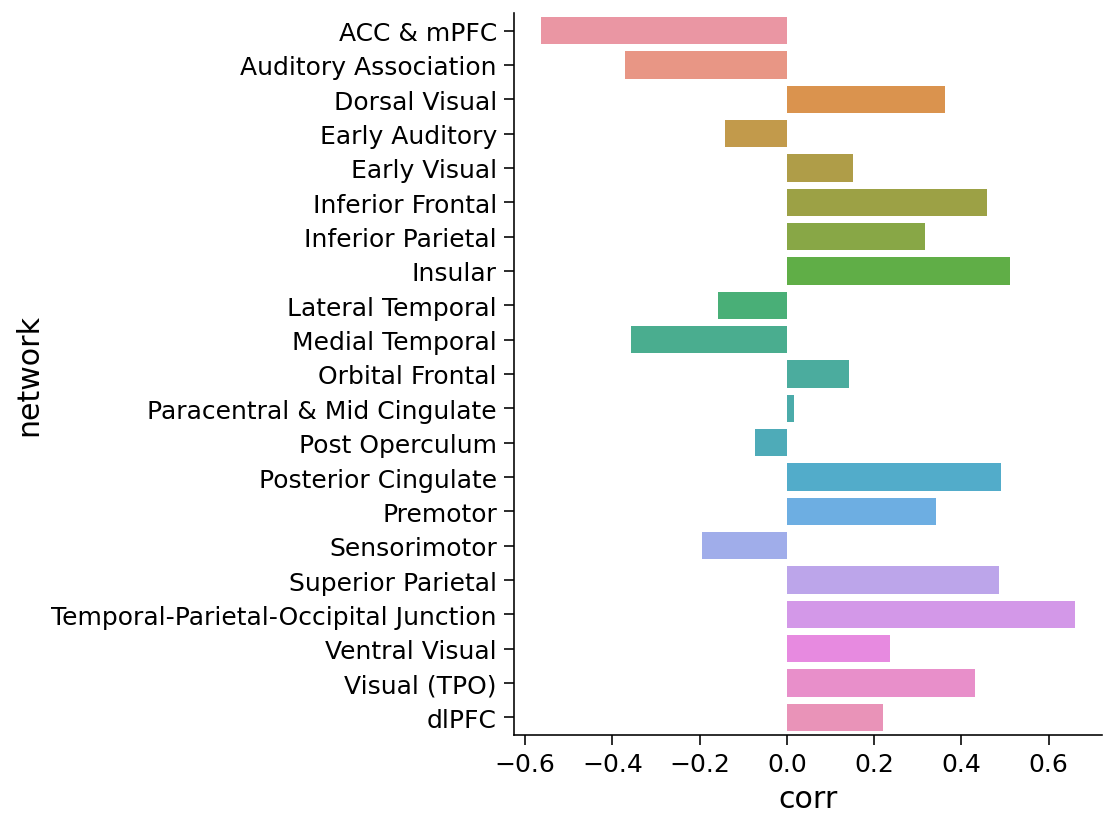

In [31]:
#plt.bar(area_names, test_score)
df = pd.DataFrame({'corr' : getscores(all_data_z),
                   'network' : area_names,})
sns.barplot(x='corr', y='network', data=df)

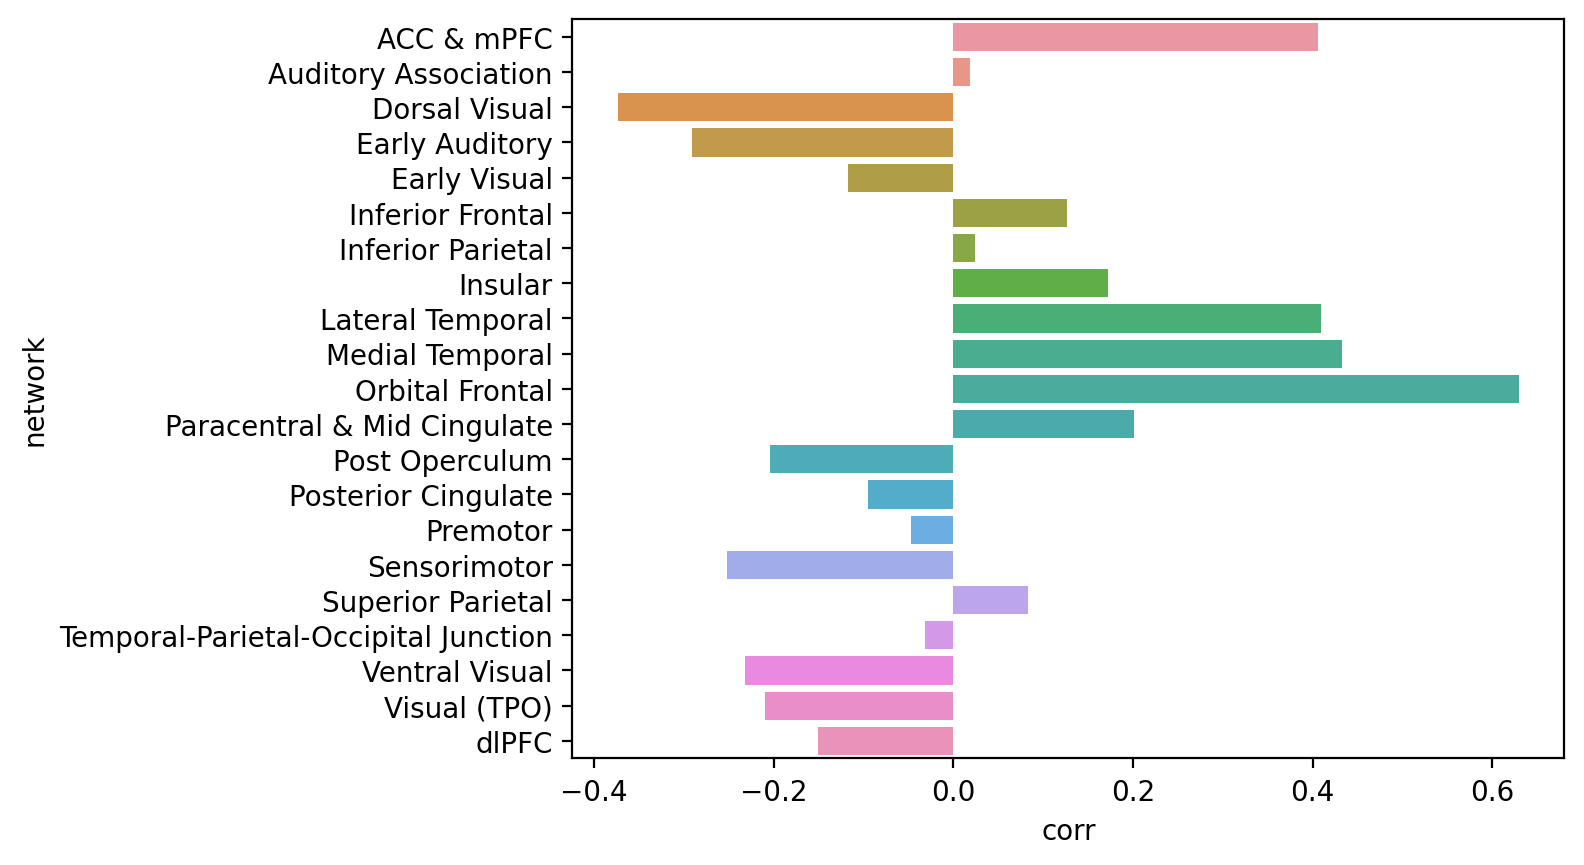

In [109]:
df = pd.DataFrame({'corr' : getscores(all_data_z),
                   'network' : area_names,})
sns.barplot(x='corr', y='network', data=df)

## PCA

Text(0, 0.5, 'Cumulative explained variance')

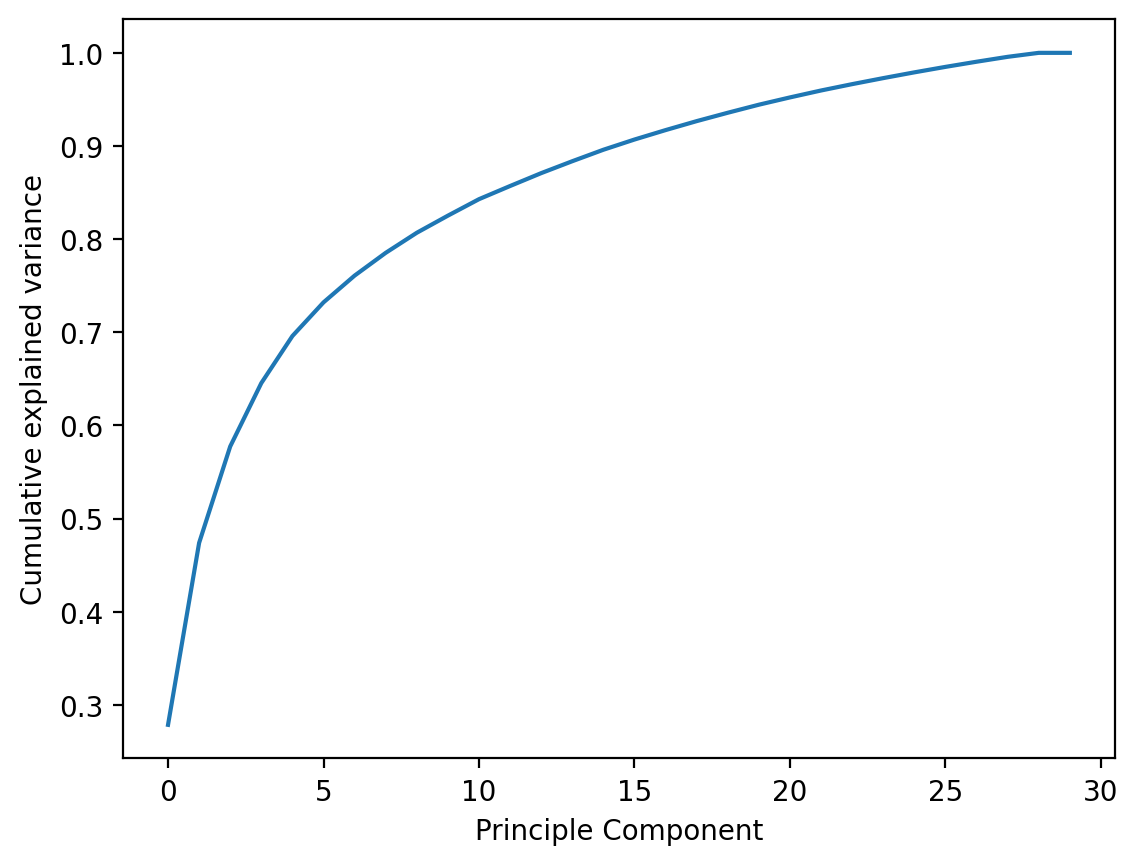

In [177]:
pca = PCA()
reduced_data = pca.fit_transform(all_data_z.T)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Principle Component")
plt.ylabel("Cumulative explained variance")

In [ ]:
reduced_data

In [ ]:
plt.plot(pca.explained_variance_ratio_)

## Train/test split

In [ ]:
reduced_data.shape

In [ ]:
all_data[:,0].shape

In [ ]:
# Train/test

X_train, X_test, y_train, y_test = train_test_split(reduced_data[:,0].reshape(-1,1), gainvector, shuffle=True, test_size=0.20, random_state=42)

## Regression

In [ ]:
# Regression
reg = LinearRegression().fit(X_train, y_train)

y_pred_train = reg.predict(X_train)
np.corrcoef(y_pred_train, y_train)

In [ ]:
y_pred_test = reg.predict(X_test.reshape(-1,1))
np.corrcoef(y_pred_test, y_test)

In [ ]:
y_pred_test.shape

## Stepwise regression

In [ ]:
stepwiseregcorrs = []
X_train, X_test, y_train, y_test = train_test_split(reduced_data, gainvector, shuffle=True, test_size=0.20, random_state=42)
yres = y_train.copy()
for i in range(len(reduced_data[0])): 
  LinearRegression().fit(X_train[:,i].reshape(-1,1), yres)
  # y_pred_train = reg.predict(X_train)
  y_pred = reg.predict(X_train[:,i].reshape(-1,1))
  #a.append([np.corrcoef(y_pred_train, y_train)[0][1], np.corrcoef(y_pred_test, y_test)[0][1]])
  stepwiseregcorrs.append(np.corrcoef(y_pred, yres)[0][1])
  yres = y_pred - yres
  #yres = yres - np.hstack((y_pred_test, y_pred_train))

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
np.argmax(np.array(stepwiseregcorrs[:-1]))

In [173]:
faulty_subjects = [5, 6, 16, 27, 38, 39, 40, 45, 50, 51, 60, 61, 62, 71, 72, 74, 76, 77, 78, 80, 81, 82]
sub_test_score = np.zeros((N_SUBJECTS-len(faulty_subjects), len(area_names)))
for sub in range(len(sub_test_score)):
  if sub not in faulty_subjects:
    my_exp = 'GAMBLING'
    my_subj = subjects[sub]
    my_run = 0
    data = load_single_timeseries(subject=my_subj, experiment=my_exp, run=my_run, remove_mean=False)
    evs = load_evs(subject=my_subj, experiment=my_exp, run=my_run)
    #print(sub)
    input_matrix = wBo(evs_delayed)
    gainvector = dcgvector(input_matrix)

    sub_all_loss = np.mean(data[:,evs_delayed[2][:]], axis=2)
    sub_all_win = np.mean(data[:,evs_delayed[3][:]], axis=2)
    sub_all_data = np.concatenate((sub_all_loss, sub_all_win), axis=1)
    sub_all_data_z = stats.zscore(sub_all_data, axis=None)

    sub_test_score[sub] = getscores(sub_all_data_z)

In [172]:
faulty_subjects = [5, 6, 16, 27, 38, 39, 40, 45, 50, 51, 60, 61, 62, 71, 72, 74, 76, 77, 78, 80, 81, 82]
sub_test_score_nodelay = np.zeros((N_SUBJECTS-len(faulty_subjects), len(area_names)))
for sub in range(len(sub_test_score_nodelay)):
  if sub not in faulty_subjects:
    my_exp = 'GAMBLING'
    my_subj = subjects[sub]
    my_run = 0
    data = load_single_timeseries(subject=my_subj, experiment=my_exp, run=my_run, remove_mean=False)
    evs = load_evs(subject=my_subj, experiment=my_exp, run=my_run)
    print(sub)
    input_matrix = wBo(evs)
    gainvector = dcgvector(input_matrix)

    sub_all_loss = np.mean(data[:,evs[2][:]], axis=2)
    sub_all_win = np.mean(data[:,evs[3][:]], axis=2)
    sub_all_data = np.concatenate((sub_all_loss, sub_all_win), axis=1)
    sub_all_data_z = stats.zscore(sub_all_data, axis=None)

    sub_test_score_nodelay[sub] = getscores(sub_all_data_z)

0
1
2
3
4
7
8
9
10
11
12
13
14
15
17
18
19
20
21
22
23
24
25
26
28
29
30
31
32
33
34
35
36
37
41
42
43
44
46
47
48
49
52
53
54
55
56
57
58
59
63
64
65
66
67
68
69
70
73
75


In [50]:
sub_test_score.mean(axis=0).shape

(21,)

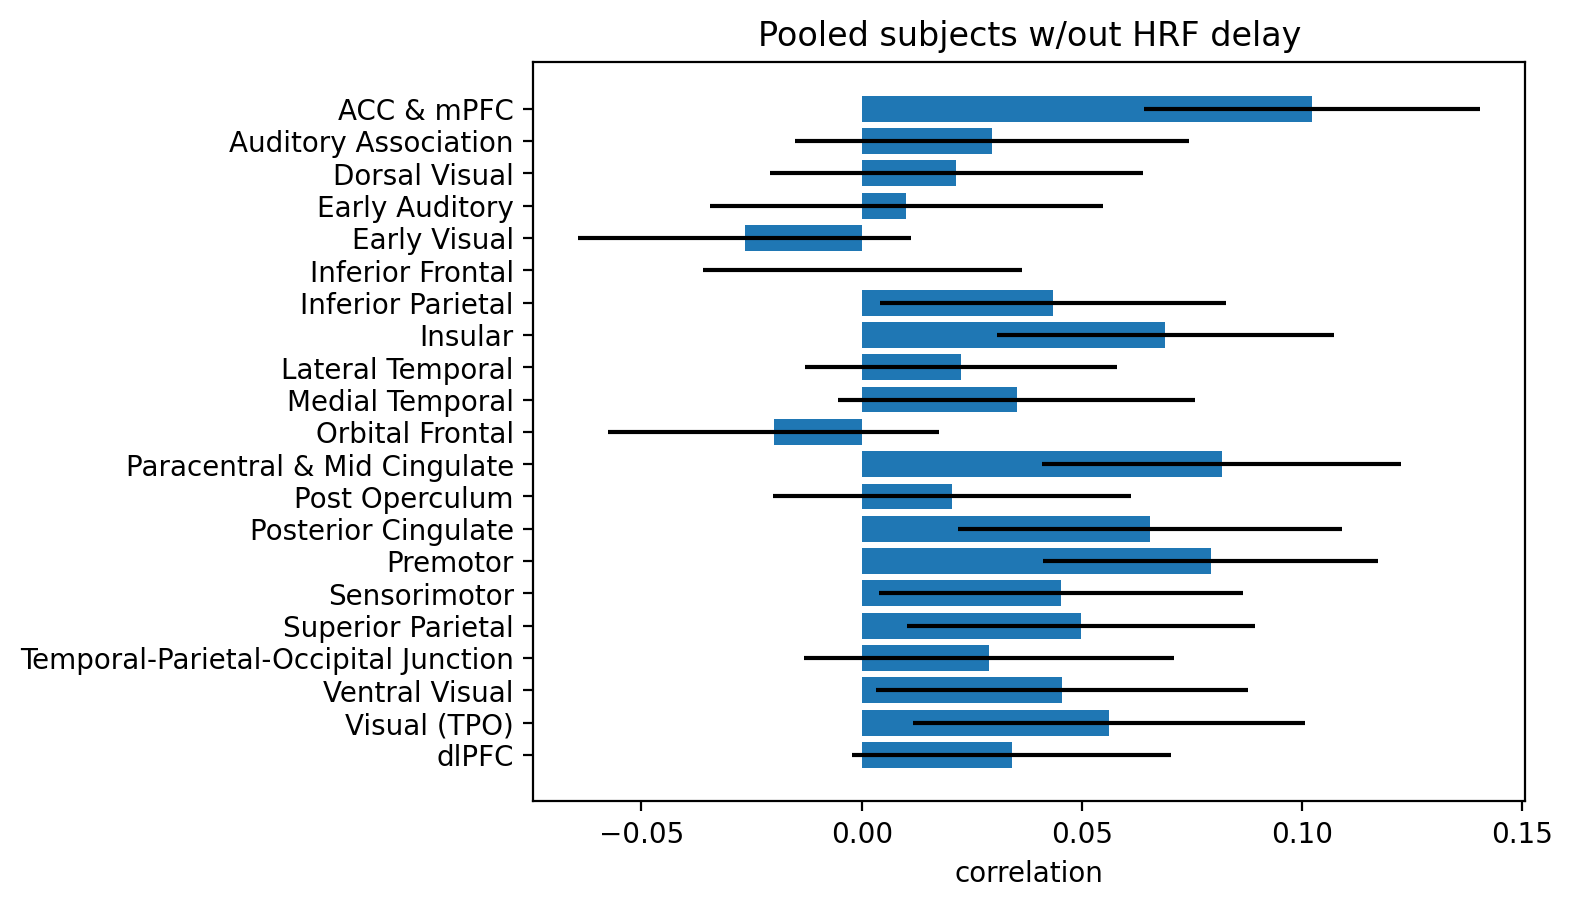

In [176]:
df = pd.DataFrame({'corr' : sub_test_score_nodelay.mean(axis=0),
                   'network' : area_names,
                   'error': sub_test_score_nodelay.std(axis=0)/np.sqrt(sub_test_score_nodelay.shape[0])})

y_pos = np.arange(len(df['network']))
plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(y_pos, df['corr'], xerr=df['error'], align='center')
plt.yticks(y_pos, df['network'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('correlation')
ax.set_title('Pooled subjects w/out HRF delay')

plt.show()

#ax = sns.barplot(data=df, x="corr", y="network", ci="sd")
#x_coords = [p.get_x() + 0.5*p.get_width() for p in ax.patches]
#y_coords = [p.get_height() for p in ax.patches]
# plt.errorbar(x=x_coords, y=y_coords, xerr=df["error"], fmt="none", c= "k")


#sns.barplot(x='corr', y='network', data=df)

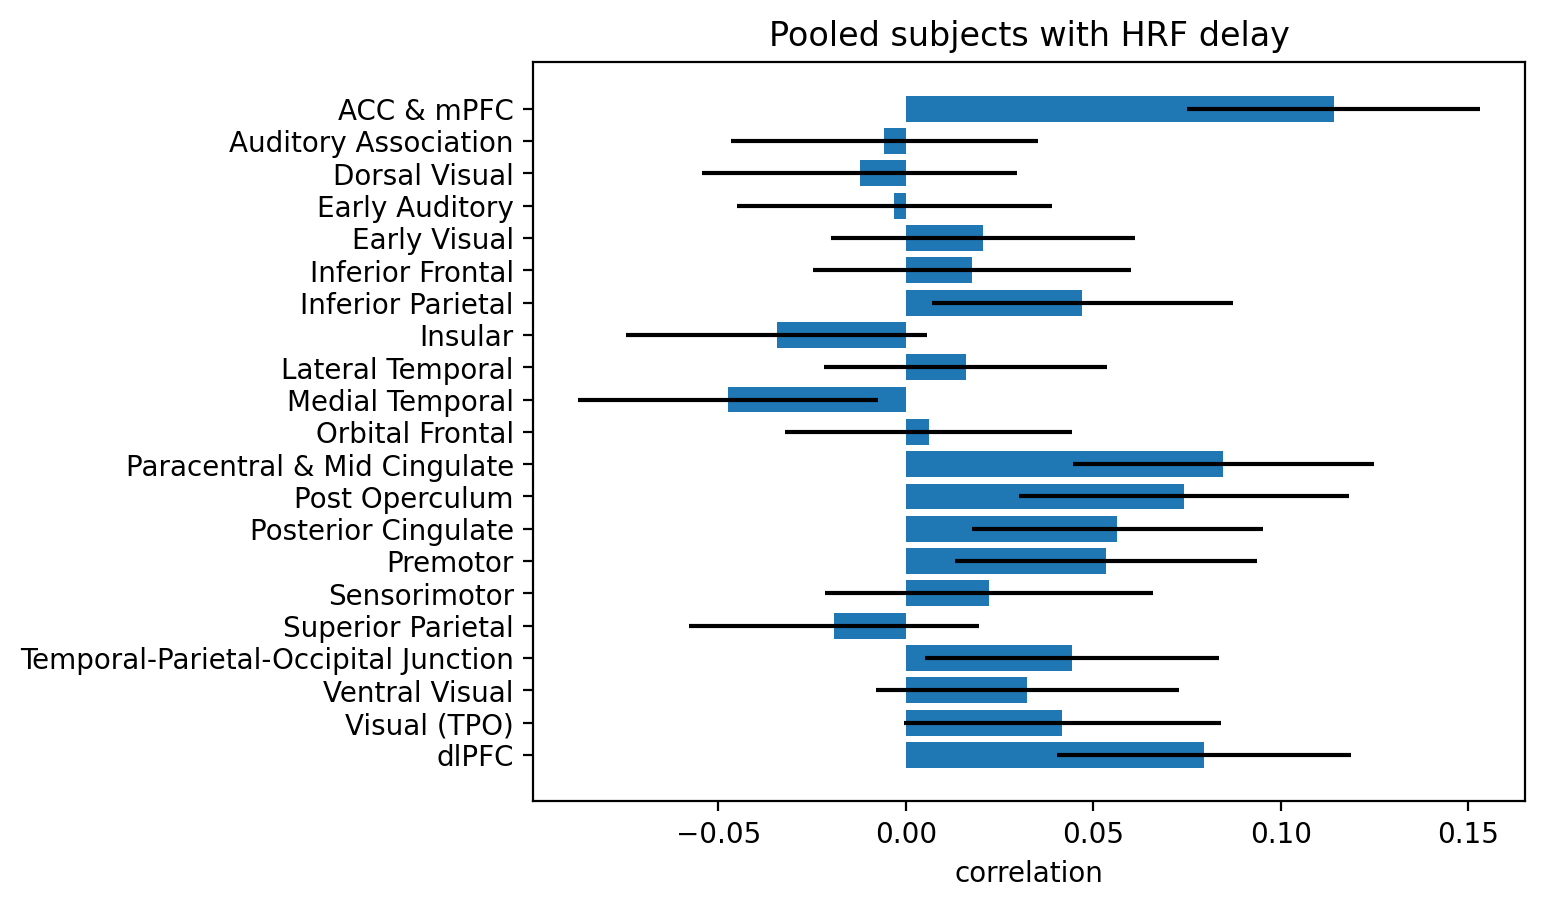

In [175]:
df = pd.DataFrame({'corr' : sub_test_score.mean(axis=0),
                   'network' : area_names,
                   'error': sub_test_score.std(axis=0)/np.sqrt(sub_test_score.shape[0])})

y_pos = np.arange(len(df['network']))
plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(y_pos, df['corr'], xerr=df['error'], align='center')
plt.yticks(y_pos, df['network'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('correlation')
ax.set_title('Pooled subjects with HRF delay')

plt.show()

In [ ]:
print(evs[0])
print(evs[2])

# Example run (cont.)

In [39]:
# we need a little function that averages all frames from any given condition
def average_frames(data, evs, experiment, cond):
  idx = EXPERIMENTS[experiment]['cond'].index(cond)
  return np.mean(np.concatenate([np.mean(data[: , evs[idx][i]], axis=1, keepdims=True) for i in range(len(evs[idx]))], axis=-1), axis=1)


loss_activity = average_frames(data, evs, my_exp, 'loss')
win_activity = average_frames(data, evs, my_exp, 'win')
contrast = loss_activity - win_activity  # difference between loss and win

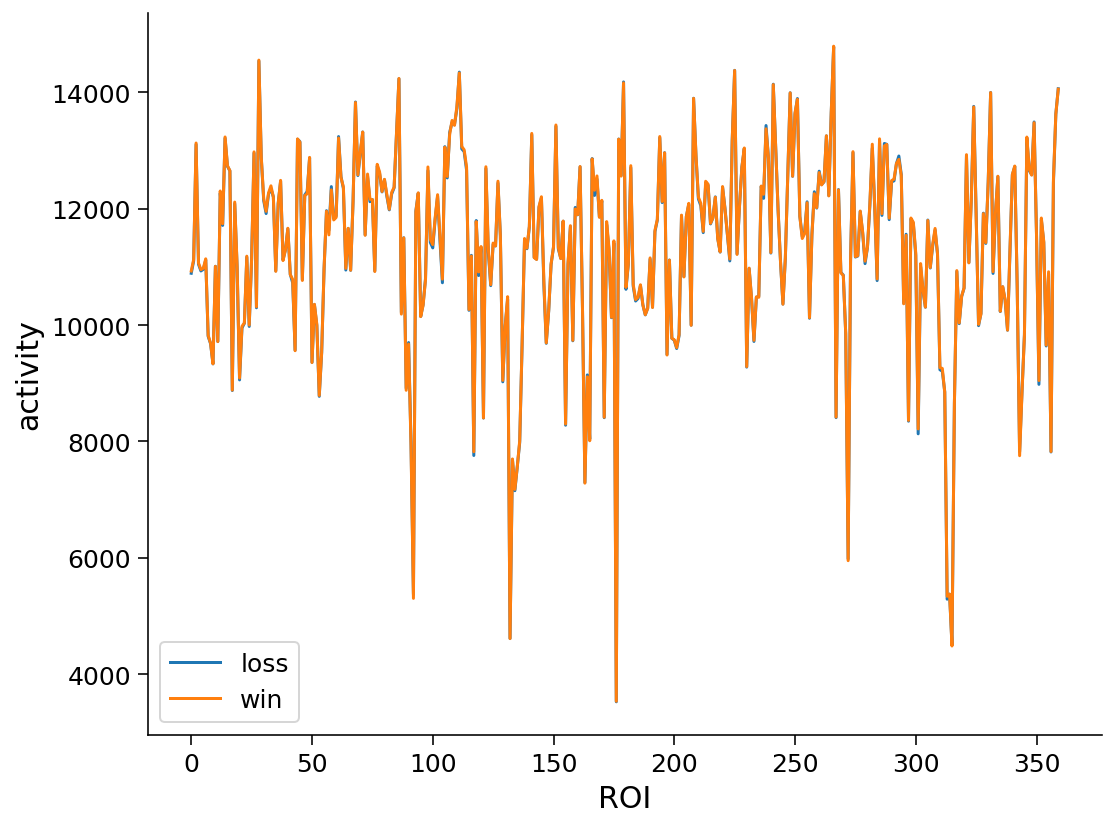

In [40]:
# Plot activity level in each ROI for both conditions
plt.plot(loss_activity,label='loss')
plt.plot(win_activity,label='win')
plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()
plt.show()

Now let's plot these activity vectors. We will also make use of the ROI names to find out which brain areas show highest activity in these conditions. But since there are so many areas, we will group them by network.

A powerful tool for organising and plotting this data is the combination of pandas and seaborn. Below is an example where we use pandas to create a table for the activity data and we use seaborn oto visualise it.





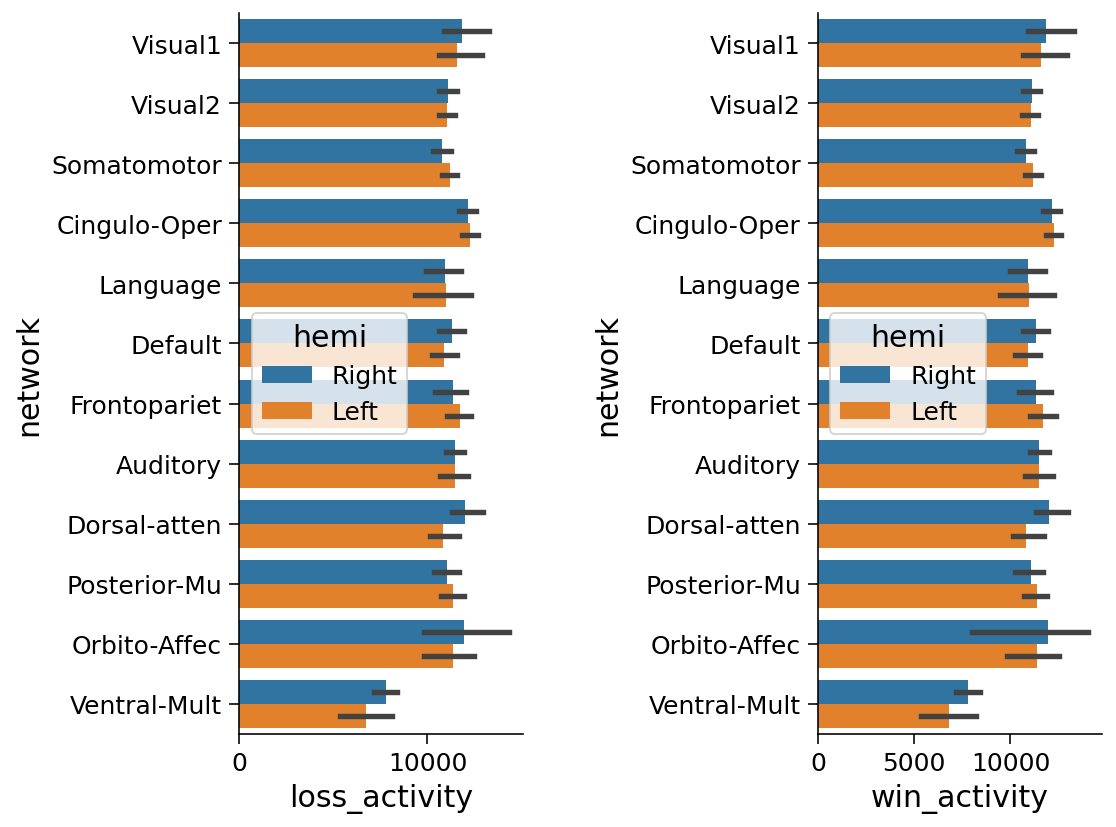

In [41]:
df = pd.DataFrame({'loss_activity' : loss_activity,
                   'win_activity' : win_activity,
                   'network' : region_info['network'],
                   'hemi' : region_info['hemi']})

fig, (ax1, ax2) = plt.subplots(1, 2)
sns.barplot(y='network', x='loss_activity', data=df, hue='hemi',ax=ax1)
sns.barplot(y='network', x='win_activity', data=df, hue='hemi',ax=ax2)
plt.show()

In [ ]:
loss_activity.shape

You should be able to notice that for the somatosensory network, brain activity in the right hemi is higher for the left foot movement and vice versa for the left hemi and right foot. But this may be subtle at the single subject/session level (these are quick 3-4min scans). 


Let us boost thee stats by averaging across all subjects and runs. 

In [121]:
group_contrast = 0
for s in subjects:
  for r in [0, 1]:
    data = load_single_timeseries(subject=s, experiment=my_exp,
                                  run=r, remove_mean=True)
    evs = load_evs(subject=s, experiment=my_exp,run=r)

    loss_activity = average_frames(data, evs, my_exp, 'loss')
    win_activity = average_frames(data, evs, my_exp, 'win')

    contrast = loss_activity - win_activity
    group_contrast += contrast

group_contrast /= (len(subjects)*2)  # remember: 2 sessions per subject

In [122]:
group_contrast.shape

(360,)

In [ ]:
group_contrast

In [ ]:
df = pd.DataFrame({'contrast' : group_contrast,
                   'network' : region_info['network'],
                   'hemi' : region_info['hemi']
                   })
# we will plot the left foot minus right foot contrast so we only need one plot
plt.figure()
sns.barplot(y='network', x='contrast', data=df, hue='hemi')
plt.show()

# Visualising the results on a brain

Finally, we will visualise these resuts on the cortical surface of an average brain.

In [116]:
# @title NMA provides an atlas. Run this cell to download it
import os, requests

# NMA provides an atlas
fname = f"{HCP_DIR}/atlas.npz"
url = "https://osf.io/j5kuc/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

with np.load(fname) as dobj:
  atlas = dict(**dobj)

In [132]:
regions['network']

IndexError: ignored

In [ ]:
parcel2area
area_info

In [123]:
sub_test_score_pw = np.zeros(360)
for i in range(len(sub_test_score_pw)):
  
  sub_test_score_pw[i] = sub_test_score[]

In [124]:
# This uses the nilearn package
from nilearn import plotting, datasets

# Try both hemispheres (L->R and left->right)
fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = sub_test_score_pw[atlas["labels_R"]]
plotting.view_surf(fsaverage['infl_right'],
                   surf_contrast,
                   vmax=20)